<a href="https://colab.research.google.com/github/TejaSreenivas/Word_Embeddings/blob/master/Pretrained_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive')
data_path = os.getcwd()+'/drive/My Drive/datasets/'
sys.path.insert(0, data_path)
os.listdir(data_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['GoogleNews-vectors-negative300.bin.gz',
 'cifar-10-batches-py',
 'mnist',
 'fashion',
 'Digital_Music_5.json',
 'News_Category_Dataset_v2.json',
 'large_imbd',
 'Consumer_Complaints.csv',
 'clustering',
 'load_mnist.py',
 '__pycache__',
 'aclImdb_v1.tar.gz',
 'load_cifar.py',
 'load_mnist.py.gdoc',
 'load_cifar.py.gdoc']

In [0]:

import numpy as np
import pandas as pd 
import pickle
import json
import gensim
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pandas.plotting import scatter_matrix

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder
from keras.optimizers import RMSprop, SGD
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Input, Bidirectional, LSTM, regularizers
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import GlobalMaxPool1D
from gensim.models import Word2Vec

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

def normalize(txt,to_lower=True):
  # Remove HTML Tags
  txt = cleanhtml(txt)
  txt = txt.split()
  # This will keep characters and other symbols
  txt = [re.sub(r'http:.*', '', r) for r in txt]
  txt = [re.sub(r'https:.*', '', r) for r in txt]
  txt = ( " ".join(txt))
  # Remove non-emoticon punctuation and numbers
  txt = re.sub("[.,!0-9]", " ", txt)
  txt = " ".join(txt.split())
  return txt

In [0]:
# What does this normalization function look like?
clean_text = normalize("This is A sentence. not good with things! 123 :) <br> and a link https://gitub.com")
print(clean_text)

This is A sentence not good with things :) and a link


In [0]:
def balance(df):
    print("Balancing the classes")
    type_counts = df['Product'].value_counts()
    min_count = min(type_counts.values)
    balanced_df = None
    for key in type_counts.keys():
        df_sub = df[df['Product']==key].sample(n=min_count, replace=False)
        if balanced_df is not None:
            balanced_df = balanced_df.append(df_sub)
        else:
            balanced_df = df_sub
    return balanced_df

In [0]:
def generate_vocab(dataset):
  max_len = 400
  max_features = 300
  vectorizer = TfidfVectorizer(norm='l2', use_idf=True, smooth_idf=True)
  response = vectorizer.fit_transform(np.array(dataset['data']))
  score = dict()
  word_list = []
  for word,idf in zip(vectorizer.vocabulary_.items(),vectorizer.idf_):
    word_list.append(word[0])
    score[word[0]] = word[1]*idf
  word_list.sort(key=lambda x: -score[x]) #sorting criteria
  return word_list
# sorting criteria
# -score[x] for descending order of tfidf
# vectorize.vocabulary_[x] for sorting by TF
# just word_list to randomized list

In [0]:
def shallow_NN(X_train,Y_train,embedding):
    # create input layer 
    model = Sequential()
    model.add(embedding)
    model.add(GlobalMaxPool1D())
    model.add(Dense(100 , activation='relu'))
    model.add(Dropout(0.7))
    #model.add(Dense(200, activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model



In [0]:
def deep_CNN(X_train,Y_train,embedding):
  model = Sequential()
  model.add(embedding)
  model.add(Conv1D(32, 3, activation='relu',padding="same"))
  model.add(Conv1D(64, 3, activation='relu'))
  model.add(Conv1D(128, 5, activation='relu',padding="same"))
  model.add(Conv1D(256, 5, activation='relu'))
  model.add(GlobalMaxPool1D())
  model.add(Dense(500,activation = 'relu'))
  model.add(Dropout(0.7))
  model.add(Dense(Y_train.shape[1], activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model


In [0]:
def BiLSTM(X_train,Y_train,embedding):
  lstm_out = 64
  model = Sequential()
  model.add( embedding )
  model.add( Bidirectional( LSTM(lstm_out, recurrent_dropout=0.7, activation='tanh')))
  model.add(Dropout(0.7))
  model.add( Dense(Y_train.shape[1], activation = 'softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  print(model.summary())
  return model

In [0]:
def Train_on_models(train,test):
  import gc
  gc.collect()
  max_features = 15000
  max_len = 400
  emb_dim = 300
  dataset = pd.concat([train,test])
  num_classes = np.unique(train['label']).shape[0]
  
    # one Hot encoding
  id_mtx = np.identity(num_classes, dtype = np.float64)
  Y_train = id_mtx[np.array(train['label'])]
  Y_test = id_mtx[np.array(test['label'])]
  
  
  model_path = data_path+"/GoogleNews-vectors-negative300.bin.gz"
  cbow = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)
  print("Words similar to good: ")
  print(cbow.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man']))
  tokenizer = Tokenizer(num_words=max_features, split=' ')
  tokenizer.fit_on_texts(dataset['data'])
  vocab_list = generate_vocab(dataset)
  X_train = tokenizer.texts_to_sequences(train['data'])
  train = None
  gc.collect()
  X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
  X_test = tokenizer.texts_to_sequences(test['data'])
  test = None
  gc.collect()
  X_test = pad_sequences(X_test, maxlen=max_len, padding='post')
  
  num_words = min(max_features, len(vocab_list))+1
  embedding_matrix = np.zeros((num_words, emb_dim))
  # create an embedding matrix for each word in our vocabulary
  word_index = tokenizer.word_index
  for word,i in word_index.items():
    if i >= max_len:
      continue
    if word in cbow.wv.vocab:
      embedding_matrix[i] = cbow.wv.word_vec(word)
  
  embedding_layer = Embedding(num_words,
                             emb_dim,
                             weights = [embedding_matrix],
                             input_length = max_len,
                             trainable = True)
  cbow=None
  gc.collect()

  # Naive Bayes is not applicable for this model
  """
  # shallow ANN
  model_nn = shallow_NN(X_train,Y_train,embedding_layer)
  hist_nn = model_nn.fit(X_train, Y_train, batch_size=32, epochs=20, verbose=1, 
            validation_data=(X_test,Y_test))
  name = os.getcwd()+"/drive/My Drive/outputs/"
  np.save(name+"pre_ann.npy",hist_nn.history)
 
  # Deep CNN
  model_cnn = deep_CNN(X_train,Y_train,embedding_layer)
  hist_cnn = model_cnn.fit(X_train, Y_train, batch_size=32, epochs=20, verbose=1, 
            validation_data=(X_test,Y_test)) 
  name = os.getcwd()+"/drive/My Drive/outputs/"
  np.save(name+"pre_cnn.npy",hist_cnn.history)
  """
  #using LSTM
  model_lstm = BiLSTM(X_train,Y_train, embedding_layer)
  hist_lstm = model_lstm.fit(X_train, Y_train, batch_size=32, epochs=20, verbose=1, 
            validation_data=(X_test,Y_test)) 
  name = os.getcwd()+"/drive/My Drive/outputs/"
  np.save(name+"pre_rnn.npy",hist_lstm.history)
  # save file
  file = dict()
  #file['NB'] = acc_NB
  """
  file['NN'] = hist_nn.history
  file['CNN'] = hist_cnn.history
  """
  file['BiLSTM'] = hist_lstm.history
  return file

## Dataset : IMDB Movie reviews

### Load and Pre-process Dataset

In [0]:
df2 = pd.read_csv(data_path+"large_imbd/imdb_master.csv",encoding="latin-1")
print(df2.head())
df2 = df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns = ["review","sentiment"]
print(df2.head())
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment'] = df2['sentiment'].map({'pos': 1, 'neg': 0})
print(df2.head())
#read datasets into dataframe
# IMDB dataset  
df2.columns = ["data","label"]
df2['data'] = np.array(df2['data'].map(normalize))
df_train, df_test = train_test_split(df2, test_size=0.5,stratify=df2['label'])


KeyboardInterrupt: ignored

### Train On the models

In [0]:
imdb = Train_on_models(df_train,df_test)

In [0]:
name = os.getcwd()+"/drive/My Drive/outputs/"+"pre_imdb.npy"
np.save(name,imdb)

## Dataset: Customer Complaint Dataset

### Load and Preprocess Dataset

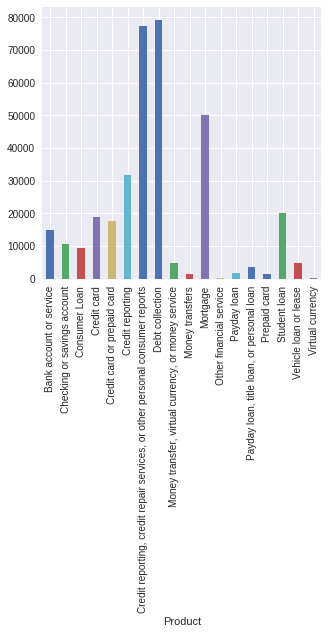

Balancing the classes
row count : 94730


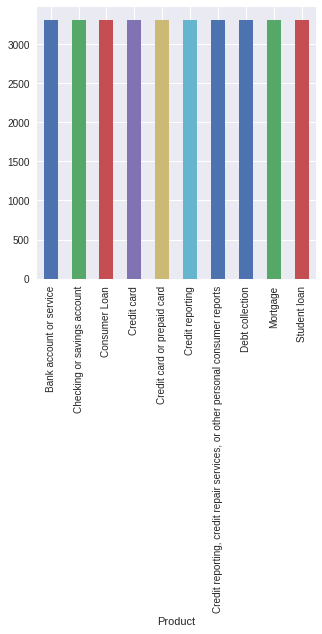

23

In [0]:
#customer complaints dataset

df = pd.read_csv(data_path+"/Consumer_Complaints.csv",sep=",")
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]

#printing the available distribution of the labels
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

#columns list to be choosen (we have choosen columns which have count nearly more than 10k) manually
cl = ['Bank account or service', 'Checking or savings account','Consumer Loan', 'Credit card', 'Credit card or prepaid card',
       'Credit reporting',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection','Mortgage', 'Student loan']
df = df[df['Product'].isin(cl)]

#balance the dataset
df_data = balance(df)
print("row count : {}".format(df_data['Product'].shape[0]))

# train and test split
train_data, test_data = train_test_split(df_data, test_size=0.5,stratify=df_data['Product'])
train_data, test_data = train_test_split(train_data, test_size=0.3,stratify=train_data['Product'])

#plot train data distribution
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
train_data.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

#rename the columns
train_data.columns = ['label','data','id']
test_data.columns = ['label','data','id']


train_data['data'] = train_data['data'].map(normalize)
test_data['data'] = test_data['data'].map(normalize)


one_hot = LabelEncoder()

# One-hot encode data
train_data['label'] = one_hot.fit_transform(train_data['label'])
test_data['label'] = one_hot.fit_transform(test_data['label'])
import gc
df_data = None
gc.collect()

(26524,)

### Train on Models

In [0]:
cust = Train_on_models(train_data, test_data)

Words similar to good: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


[('queen', 0.9314123392105103), ('monarch', 0.858533501625061), ('princess', 0.8476566076278687), ('Queen_Consort', 0.8150269985198975), ('queens', 0.8099815249443054), ('crown_prince', 0.808997631072998), ('royal_palace', 0.8027306795120239), ('monarchy', 0.801961362361908), ('prince', 0.800979733467102), ('empress', 0.7958388328552246)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 300)          4500300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 4,688,470
Trainable params: 4,688,470
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 33155 samples, 

In [0]:
name = os.getcwd()+"/drive/My Drive/outputs/"+"pre_cust_rnn.npy"
np.save(name,cust)